### Import libraries

In [168]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import re
import string

import nltk
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import seaborn as sns

In [133]:
%config Completer.use_jedi = False

In [46]:
pd.set_option("max_colwidth", 200)

### Load dataset 

In [139]:
news_df = pd.read_csv('news.csv', encoding='UTF-8')
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [140]:
label_df = news_df.label
label_df.head()
label_df.info()

<class 'pandas.core.series.Series'>
RangeIndex: 6335 entries, 0 to 6334
Series name: label
Non-Null Count  Dtype 
--------------  ----- 
6335 non-null   object
dtypes: object(1)
memory usage: 49.6+ KB


REAL    3171
FAKE    3164
Name: label, dtype: int64

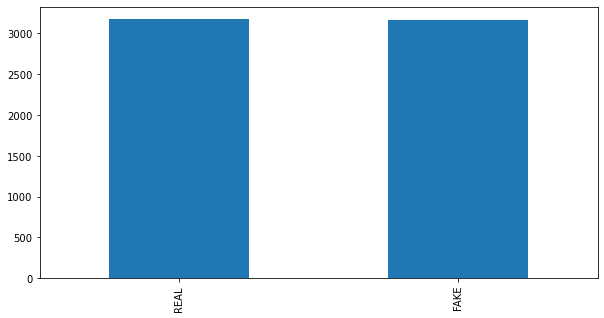

In [141]:
## Count of real(1) or fake texts
news_df['label'].value_counts().plot(kind='bar', figsize=(10,5))
news_df['label'].value_counts()
# ## Text length
# news_df['text_len'] = train_pd['text'].apply(lambda x: len(x) - x.count(" "))
# print(train_pd['text_len'])

In [142]:
news_df.drop('label', axis=1, inplace=True)

### Pre-process data 

In [143]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
dtypes: int64(1), object(2)
memory usage: 148.6+ KB


In [144]:
news_df.drop('Unnamed: 0', axis=1, inplace=True)

In [145]:
news_df.head()

,title,text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. \nIn the final stretch of the election, Hillary Rodham Clinton has gone to wa..."
1,Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO),Google Pinterest Digg Linkedin Reddit Stumbleupon Print Delicious Pocket Tumblr \nThere are two fundamental truths in this world: Paul Ryan desperately wants to be president. And Paul Ryan will ne...
2,Kerry to go to Paris in gesture of sympathy,"U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerr..."
3,Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!',"— Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. \n— People F..."
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners Hillary Clinton and Donald Trump are leading in the polls.\n\nTrump is now vowing to win enough delegates to clinch the Republican nomination and pre...


In [146]:
# Contraction
contractions_dict = {     
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [147]:
## Formatting text
def format_text(text):
    
    ## Remove hyperlinks
    url = '((http|https)?\://t.co\/[a-zA-Z0-9]+)|(http://|https://|http|https)?|((http|https)?\:\s\\\/\\\/t.co\\\/[a-zA-Z0-9]+)'
    text = re.sub(url, "", text)
    
    ## Remove alphanumeric
    alphnum = '\w*\d\w*'
    text = re.sub(alphnum, "", text)
    
    ## Remove html tags
    html = re.compile(r'<.*?>')
    text = html.sub(r'',text)
    
    ## Remove contractions
    def expand_contractions(text, contractions_dict):
        contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contractions_dict.get(match) \
                if contractions_dict.get(match) \
                else contractions_dict.get(match.lower())
            expanded_contraction = expanded_contraction
            return expanded_contraction

        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text

    text = expand_contractions(text, contractions_dict)
    
    ## Remove junk character
    text = text.encode("ascii", "ignore").decode("utf-8", "ignore")    

    ## Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    
    ## Remove white spaces
    text = " ".join(text.split())
    
    ## Tokenize tweets
    text = word_tokenize(text.lower())
    
    ## Remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    
    ## Apply lemmatization
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    
    return text

#X_train['text'] = [format_text(text) for text in tqdm(X_train['text'])]
#X_train['title'] = [format_text(text) for text in tqdm(X_train['title'])]

#### TF-IDF 

In [150]:
tfidf1 = TfidfVectorizer(analyzer=format_text)
train_tfidf1 = tfidf1.fit_transform(news_df['text'])

In [151]:
tfidf2 = TfidfVectorizer(analyzer=format_text)
train_tfidf2 = tfidf2.fit_transform(news_df['title'])

#### Saving the TF-IDF model

In [152]:
## For 'text' column
pickle.dump(tfidf1, open('tfidf_model1.pkl', 'wb'))
train_df = pd.DataFrame(train_tfidf1.toarray())
train_df.columns = tfidf1.get_feature_names()
print(train_df.shape)
train_df

(6335, 80392)


C:\ProgramData\Anaconda3\envs\fake_news\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,aaaa,aaaaadd,aaaasetlayoutnew,aab,aachen,aadhar,aadmi,aae,...,zvezda,zvi,zvulun,zwanzig,zweiter,zwick,zwicker,zwischenmenschlicher,zyuganov,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
## For 'title' column
pickle.dump(tfidf2, open('tfidf_model2.pkl', 'wb'))
train_df1 = pd.DataFrame(train_tfidf2.toarray())
train_df1.columns = tfidf2.get_feature_names()
print(train_df1.shape)
train_df1

(6335, 9025)


C:\ProgramData\Anaconda3\envs\fake_news\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aap,abandon,abandoned,abandoning,abby,abc,abcwapo,abducts,abdullah,abedin,...,zika,zimbabwe,zion,zionist,zip,zone,ztech,zuckerberg,zuesse,zulu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train model 

#### Random forest 

In [153]:
## Based on 'text' column

X_train, X_test, y_train, y_test = train_test_split(train_df, label_df, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)
sorted(zip(rf_model.feature_importances_,  X_train.columns), reverse=True)[0:10]
yrf_pred = rf_model.predict(X_test)

In [166]:
## Based on 'title' column

X_train, X_test, y_train, y_test = train_test_split(train_df1, label_df, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)
sorted(zip(rf_model.feature_importances_,  X_train.columns), reverse=True)[0:10]
yrf_pred = rf_model.predict(X_test)

##### Confusion matrix based on 'text' column

Accuracy: 0.9084451460142068
Precision: 0.9084451460142068
Recall: 0.9084451460142068
              precision    recall  f1-score   support

        FAKE       0.92      0.90      0.91       642
        REAL       0.90      0.92      0.91       625

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



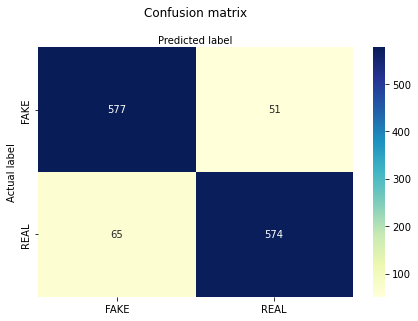

In [164]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, yrf_pred)

class_names = list(np.unique(y_train)) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(y_test, yrf_pred))
print("Precision:",metrics.precision_score(y_test, yrf_pred,average='micro'))
print("Recall:",metrics.recall_score(y_test, yrf_pred,average='micro'))

LabelScore = metrics.classification_report(yrf_pred, y_test)
print(LabelScore)

##### Confusion matrix based on 'title' column 

Accuracy: 0.8003157063930545
Precision: 0.8003157063930545
Recall: 0.8003157063930545
              precision    recall  f1-score   support

        FAKE       0.85      0.77      0.81       697
        REAL       0.75      0.84      0.79       570

    accuracy                           0.80      1267
   macro avg       0.80      0.80      0.80      1267
weighted avg       0.81      0.80      0.80      1267



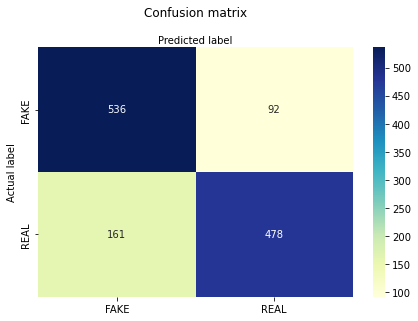

In [167]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, yrf_pred)

class_names = list(np.unique(y_train)) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(y_test, yrf_pred))
print("Precision:",metrics.precision_score(y_test, yrf_pred,average='micro'))
print("Recall:",metrics.recall_score(y_test, yrf_pred,average='micro'))

LabelScore = metrics.classification_report(yrf_pred, y_test)
print(LabelScore)

#### Support Vector Classifier 

In [169]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label_df, test_size=0.2, random_state=42)
svc = SVC(C=1, kernel='linear', degree=3, gamma='auto')
svc_model = svc.fit(X_train, y_train)
ysvc_pred = svc_model.predict(X_test)

##### Confusion matrix 

Accuracy: 0.9321231254932912
Precision: 0.9321231254932912
Recall: 0.9321231254932912
              precision    recall  f1-score   support

        FAKE       0.95      0.92      0.93       646
        REAL       0.92      0.95      0.93       621

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



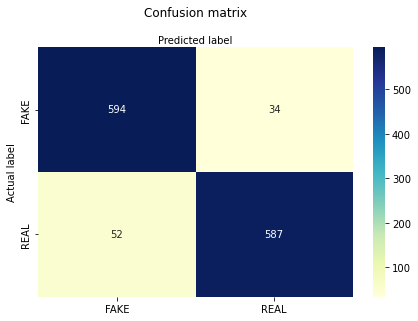

In [170]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, ysvc_pred)

class_names = list(np.unique(y_train)) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(y_test, ysvc_pred))
print("Precision:",metrics.precision_score(y_test, ysvc_pred,average='micro'))
print("Recall:",metrics.recall_score(y_test, ysvc_pred,average='micro'))

LabelScore = metrics.classification_report(ysvc_pred, y_test)
print(LabelScore)